In [1]:
import numpy as np
import matplotlib.pyplot as plt

font = {'family' : 'normal',
        'weight' : 'bold',
        'size': 16}
plt.rc('font', **font)

from hw3 import *
from hw4 import *

In [93]:
def hw3(fb, N):
    decod_dicts = []
    steps = []
    lens = []
    coded_strings = bitarray()
    data8bits = []
    for i in range(N):
        step_size = (float(np.max(fb.y2[i, :])) - float(np.min(fb.y2[i, :]))) / 2**8
        data8bit = (fb.y2[i, :] / step_size).astype(np.int8)
        data8bits.append(data8bit)
        huffman = Huffman(data8bit)
        decod_dict, coded_string = huffman.encode()
        decod_dicts.append(decod_dict)
        lens.append(len(coded_string))
        coded_strings.extend(coded_string)
        steps.append(step_size)
    return steps, decod_dicts, coded_strings, data8bits, lens

def snr(x, x_hat, N):
    x1 = x[:-2*N]
    x_hat1 = x_hat[2*N:]
    return (np.sum(np.abs(x1)) / np.sum(np.abs(x1 - x_hat1)))**2

def map2hz_mat1(W, nfft):
    nfreqs = int(nfft/2)
    tmp1 = np.diag((1.0/(np.sum(W,1)+0.01))**0.5)
    W_inv = np.dot(np.diag((1.0/(np.sum(W,1)+0.01))**0.5), W[:,0:nfreqs + 1]).T
    return W_inv

In [94]:
# mdct -> masking threshold -> quantization -> coding

def main(x0, quality, st, alpha, N, is_temporal=False):
    nfft = 2*(N-1)
    fb = Filter_banks(x0, N)
    if is_temporal:
        fb.h_n = np.sin(np.pi/(2*N) * (np.arange(int(2*N))+0.5)) * np.sqrt(2/N)
    fb.analysis()

    W, nfilts, max_brk = map2brk_mat(fs, nfft)
    Zxx_brk = map2brk(fb.y2, W, nfft)
    sf_mat = SF_mat(max_brk, nfilts, alpha)
    W_inv = map2hz_mat1(W, nfft)

    bit_steps_mat = np.zeros((fb.y2.shape[0], fb.y2.shape[1]//st), dtype=np.float32)
    new_steps = np.zeros((fb.y2.shape[0], fb.y2.shape[1]//st), np.float32)
    x2 = np.zeros_like(fb.y2)

    for i in range(fb.y2.shape[1]//st):  # 160
        x1 = Zxx_brk[i*st, :]
        mt_bark2 = MTQ_bark(x1, sf_mat, max_brk, nfilts, alpha) * quality
        mt2 = map2hz(mt_bark2, W_inv, nfft)

        steps = mt2.copy()
        bit_steps_mat[:, i] = steps

    for i in range(N):
        num_steps = (np.max(fb.y2[i, :]) - np.min(fb.y2[i, :])) / bit_steps_mat[i, :]
        num_steps[num_steps > 10**6] = 10**6
        num_steps_new = 2 ** np.ceil(np.log2(num_steps))
        new_steps[i, :] = (np.max(fb.y2[i, :]) - np.min(fb.y2[i, :])) / num_steps_new #/ (2**bit_steps_mat[i, :])
        for j in range(fb.y2.shape[1]//st):
            x2[i, st*j:st*j+st] = fb.y2[i, st*j:st*j+st] / new_steps[i, j]

    x2 = x2.astype(np.int32)
    
    # hw4
    pickle.dump([new_steps, x2], open(encoded_hw4, "wb"), 1) 
    x_hat = np.zeros_like(x2)
    for i in range(x2.shape[1]):
        x_hat[:, i] = x2[:, i] * new_steps[:, i//st]
    x_hw4 = fb.synthesis(x_hat)

    decod_dicts = []
    steps = []
    lens = []
    coded_strings = bitarray()
    data8bits = []

    for i in range(N):
        huffman = Huffman(x2[i, :])
        decod_dict, coded_string = huffman.encode()
        decod_dicts.append(decod_dict)
        lens.append(len(coded_string))
        coded_strings.extend(coded_string)

    # hw6
    pickle.dump([new_steps, decod_dicts, coded_strings, lens], open(encoded_hw6, "wb"), 1)
    
    # decode 2
    [new_steps_dec, decod_dicts_dec, coded_strings_dec, lens_dec] = pickle.load(open(encoded_hw6, "rb"))

    r = 0
    y2_dec1 = np.zeros_like(x2)
    y2_dec2 = np.zeros_like(x2)
    for i in range(N):
        try:
            y2_dec1[i, :] = decode_h(decod_dicts_dec[i], coded_strings_dec[r:r+lens[i]])
        except:
            pass
        y2_dec2[i, :] = y2_dec1[i, :] * np.repeat(new_steps_dec[i], st)
        r += lens[i]
    x_hat2 = fb.synthesis(y2_dec2)
    
    wavfile.write("restored.wav", rate=fs, data=x_hat2.astype(np.int16))
    
    # hw3
    #steps, decod_dicts, coded_strings, data8bits, lens
    tmp1 = hw3(fb, N)
    pickle.dump([*tmp1], open(encoded_hw3, "wb"), 1)
    [new_steps_dec, decod_dicts_dec, coded_strings_dec, lens_dec] = pickle.load(open(encoded_hw6, "rb"))

    x_hw3 = fb.synthesis(tmp1[3])
    
    
    wavfile.write("restored.wav", rate=fs, data=x_hat2.astype(np.int16))
    
    print("Raw data:", duration * 16 / 1024)
    print("Quantization + Huffman", os.path.getsize(encoded_hw3) / 1024, ", SNR:", snr(x0, x_hw3, N))
    print("Quantization + MT:", os.path.getsize(encoded_hw4) / 1024, ", SNR:", snr(x0, x_hw4, N))
    print("Quantization + MT + Huffman:", os.path.getsize(encoded_hw6) / 1024, ", SNR:", snr(x0, x_hat2, N))
    
    mt_new = np.zeros((N))
    for i in range(x2.shape[1]):
        x1_i = Zxx_brk[i, :]
        mt_bark2_i = MTQ_bark(x1_i, sf_mat, max_brk, nfilts, alpha)
        mt2_i = map2hz(mt_bark2_i, W_inv, nfft)
        mt_new += mt2_i
    mt_new /= x2.shape[1]

    fig = plt.figure(figsize = (10, 6))
    ax = fig.add_subplot()
    ax.semilogy(mt_new)
    ax.semilogy(new_steps.mean(axis=1))
    plt.legend(["Masking threshold", "Quantization error"])
    plt.xlabel("MDCT bands")
    plt.grid()
    plt.show()

In [95]:
from scipy.io import wavfile

castanets_file = "castanets_16.wav"
rock_file = "rockyou_16.wav"
speech_file = "speech_16.wav"

encoded_hw6 = "encoded_hw6.bin"
encoded_hw3 = "encoded_hw3.bin"
encoded_hw4 = "encoded_hw4.bin"

In [96]:
start = 0
duration = 102_400*3

Raw data: 4800.0
Quantization + Huffman 1139.1474609375 , SNR: 1.0018432719855692
Quantization + MT: 1825.0810546875 , SNR: 90.05658000012212
Quantization + MT + Huffman: 1406.12109375 , SNR: 90.05658000012212


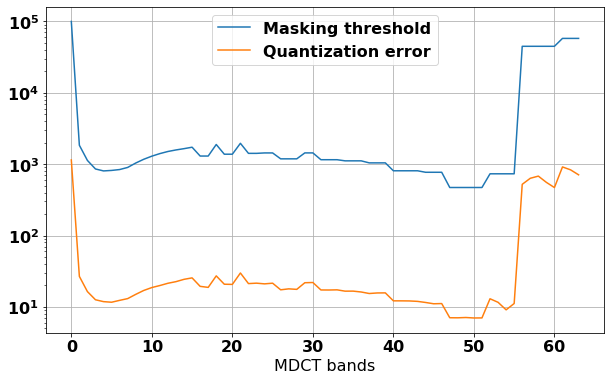

In [97]:
fs, data = wavfile.read(rock_file)
x0 = data[start:start+duration]

main(x0, quality=0.02, st=8, alpha=0.6, N=64)

Raw data: 4800.0
Quantization + Huffman 892.7705078125 , SNR: 1.0068298209640736
Quantization + MT: 1458.2080078125 , SNR: 3.461266349063503
Quantization + MT + Huffman: 577.01953125 , SNR: 3.461266349063503


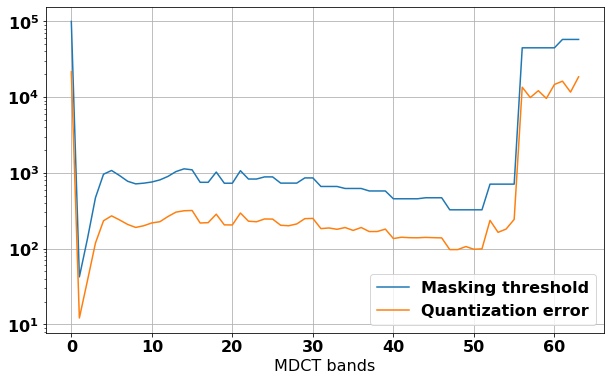

In [100]:
fs, data = wavfile.read(castanets_file)
x0 = data[start:start+duration]

main(x0, quality=0.4, st=12, alpha=0.6, N=64)

Raw data: 3200.0
Quantization + Huffman 1168.01171875 , SNR: 1.0044421868540787
Quantization + MT: 1132.787109375 , SNR: 3.1062523965344915
Quantization + Huffman + MT: 610.5322265625 , SNR: 3.1062523965344915


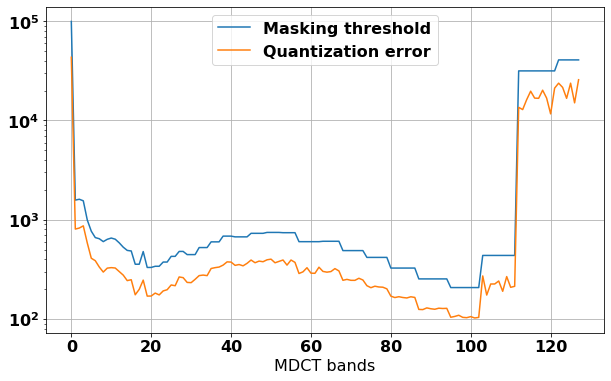

In [29]:
fs, data = wavfile.read(speech_file)
x0 = data[start:start+duration]

main(x0, quality=0.7, st=10, alpha=0.7, N=128)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


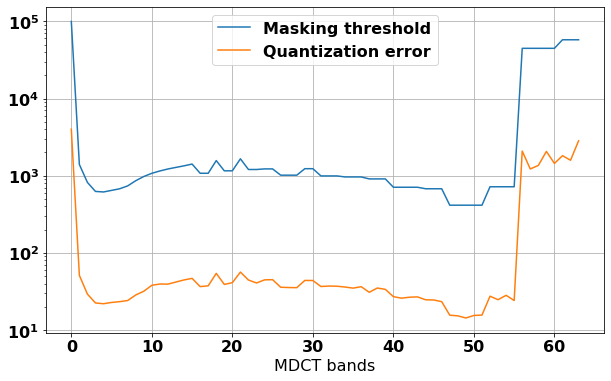

In [8]:
mt_new = np.zeros((N))
for i in range(x2.shape[1]):
    x1_i = Zxx_brk[i, :]
    mt_bark2_i = MTQ_bark(x1_i, sf_mat, max_brk, nfilts, alpha) #* quality    # /(quality/100)
    mt2_i = map2hz(mt_bark2_i, W_inv, nfft)
    mt_new += mt2_i
mt_new /= x2.shape[1]

i = 100
x1_i = Zxx_brk[i, :]
mt_bark2_i = MTQ_bark(x1_i, sf_mat, max_brk, nfilts, alpha) #* quality    #/(quality/100)
mt2_i = map2hz(mt_bark2_i, W_inv, nfft)

fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot()
#ax.semilogy(mt2_i)
#ax.semilogy((new_steps[:, i//st]))
ax.semilogy(mt_new)
ax.semilogy(new_steps.mean(axis=1))
plt.legend(["Masking threshold", "Quantization error"])
plt.xlabel("MDCT bands")
plt.grid()
plt.show()

In [9]:
# decode 1
[new_steps_dec, x2_dec] = pickle.load(open(encoded, "rb"))

x_hat = np.zeros_like(x2_dec)
for i in range(x2_dec.shape[1]):
    x_hat[:, i] = x2_dec[:, i] * new_steps_dec[:, i//st]
x_hat1 = fb.synthesis(x_hat)

In [10]:
# decode 2
[new_steps_dec, decod_dicts_dec, coded_strings_dec, lens_dec] = pickle.load(open(encoded_hw3, "rb"))

r = 0
y2_dec1 = np.zeros_like(x2_dec)
y2_dec2 = np.zeros_like(x2_dec)
for i in range(N):
    try:
        y2_dec1[i, :] = decode_h(decod_dicts_dec[i], coded_strings_dec[r:r+lens[i]])
    except:
        print(i)
    y2_dec2[i, :] = y2_dec1[i, :] * np.repeat(new_steps_dec[i], st)
    r += lens[i]
x_hat2 = fb.synthesis(y2_dec2)

52
53
54
56
57
58
59
60
61
62
63


In [11]:
wavfile.write("restored1.wav", rate=fs, data=x_hat1.astype(np.int16))
wavfile.write("restored2.wav", rate=fs, data=x_hat2.astype(np.int16))

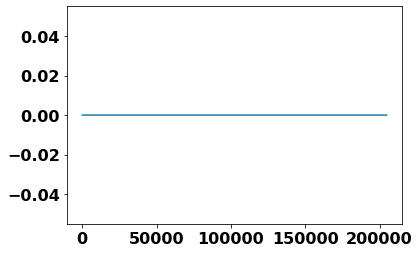

In [12]:
plt.plot(x_hat1 -x_hat2)

In [14]:
np.argmax((x_hat1 -x_hat2))

0

In [250]:
(x_hat2 - x_hat1)[10000:10100], np.sum(np.abs(x_hat2 - x_hat1))/ duration

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 3.311311078601401)

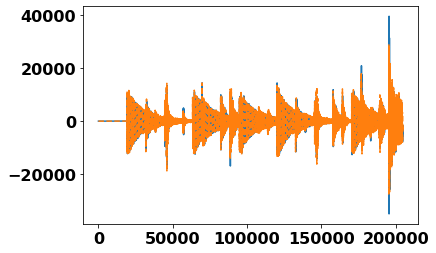

In [169]:
plt.plot(x_hat1)
plt.plot(x0, '--')
plt.show()

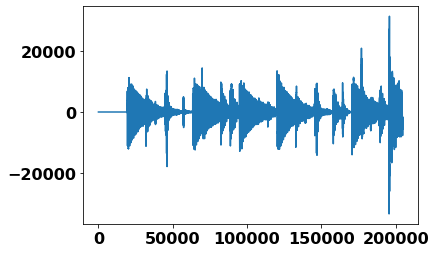

In [168]:
plt.plot(x_hat2)
#plt.plot(x0, '--')
plt.show()

In [64]:
# not use

#for i, s in enumerate(huffman1.sorted_dict):
    
i = 0
#print(i, s, huffman1.sorted_dict[s])
x = huffman1.nodes[0][i]
cod = ''
#print('len_dict:', len(self.sorted_dict))
for k in range(len(huffman1.sorted_dict)):
    #print(k)
    if x.parent_from_left:
        x = x.parent_from_left
        if x is None:
            break
        cod += '0'
    else:
        x = x.parent_from_right
        if x is None:
            break
        cod += '1'
        
print(cod)

#print(1) if huffman1.cod_dict else print(0)
huffman1.cod_dict
huffman1.cod_dict.items()


#decod_dicts[1]
#x2[1, :40]
#new_steps[1, new_steps[1, :] < 1]
#new_steps[:, :10]
#fb.y2.shape
#num_steps
decod_dicts[56], x2[56, :40]

000


In [46]:
x2_dec.shape

(64, 1600)

In [130]:
x2.flatten().max()

536

In [118]:
x2[:, k], new_steps[:, k//st]

(array([ 39,  42,  -6,   1,  10,  -7,   0,   0,   0,   0, -12,  -1,   2,
          0,  -1,  -1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]),
 array([ 742,  926, 1224,  516,  262,  238,  389,  191,  287,  269,  112,
         305,  245,  182,  172,  363,  282,   89,  207,  120,  271,  219,
          93,  182,  127,   93,  299,  193,  175,  286,  323,  234,  469,
         520,  385,  479,  462, 1079,  735,  675,  736, 1199, 1298,  573,
         493,  609,  739, 1016,  652,  429,  598,  659,  693,  890,  566,
         461, 1267, 1809, 1581, 1723, 1005,  453,  109,   30]))

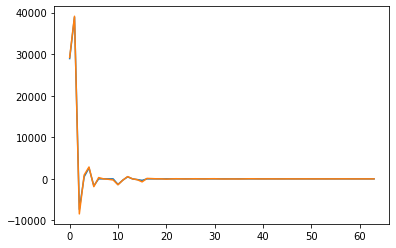

In [119]:
fb.y2.shape, new_steps.shape, Zxx_brk.shape, x2.shape
k = 100
plt.plot(x2[:, k] * new_steps[:, k//st])
plt.plot(fb.y2[:, k])

In [8]:
np.repeat(np.arange(5), 3)

array([0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4])

In [88]:
# decode (old)
x_hat = np.zeros_like(fb.y2)
for i in range(fb.y2.shape[1]):
    x_hat[:, i] = x2[:, i] * new_steps[:, i] #2**bit_steps_mat[:, i//st]
x_hat1 = fb.synthesis(x_hat)

#steps_mat.shape

In [68]:
# mdct -> masking threshold -> quantization -> coding
# old

fb = Filter_banks(x0, N)
fb.analysis()

W, nfilts, max_brk = map2brk_mat(fs, nfft)
Zxx_brk = map2brk(fb.y2, W, nfft)**2
sf_mat = SF_mat(max_brk, nfilts)
W_inv = map2hz_mat1(W, nfft)

bit_steps_mat = np.zeros_like((fb.y2), dtype=np.int)
new_steps = np.zeros_like((fb.y2), np.int)
x2 = np.zeros_like(fb.y2)

decod_dicts = []
steps = []
lens = []
coded_strings = bitarray()
data8bits = []

for i in range(Zxx_brk.shape[0]):  # 1600
    x1 = Zxx_brk[i, :]
    #sf_mat = SF_mat(max_brk, nfilts)
    #mt_bark = MT_bark(x1, sf_mat, max_brk)
    mt_bark2 = MTQ_bark(x1, sf_mat, max_brk, nfilts) /(quality/100)
    mt2 = map2hz(mt_bark2, W_inv, nfft)
    
    steps = np.sqrt(12*mt2)
    bit_steps = pow2(steps)
    #new_steps = steps.astype(np.int8)
    a = np.min(bit_steps) - 1
    bit_steps -= a
    bit_steps_mat[:, i] = bit_steps
    
for i in range(N):
    new_steps[i, :] = 1+(np.max(fb.y2[i, :]) - np.min(fb.y2[i, :])) / (2**bit_steps_mat[i, :])
    x2[i, :] = fb.y2[i, :] / new_steps[i, :]


x2 = x2.astype(np.int)
#pickle.dump([new_steps, x2], open(encoded, "wb"), 1) 


In [23]:
fb.y2.shape, new_steps.shape, Zxx_brk.shape, steps_mat.shape
#x_hat1.shape, (x2*new_steps).shape

((64, 1600), (64,), (1600, 39), (64, 1600))

In [13]:
mt_bark2.shape

W_inv = map2hz_mat1(W, nfft)
mt2 = map2hz(mt_bark2, W_inv, nfft)

In [48]:
def pow2(x):
    return np.ceil(np.log2(x))

#pow2([10, 18, 19, 31])

In [8]:
main([*x[:, 0], *x[:, 1]])

NameError: name 'main' is not defined